# MCEVAL Metrics


## MatchEndpoints
## DTW
## Pass@1
## BLEU

Comparing logs: 100%|██████████| 186/186 [00:28<00:00,  6.62it/s]


<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

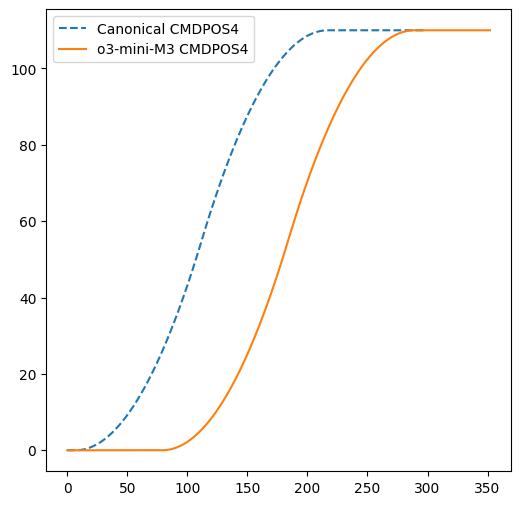

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

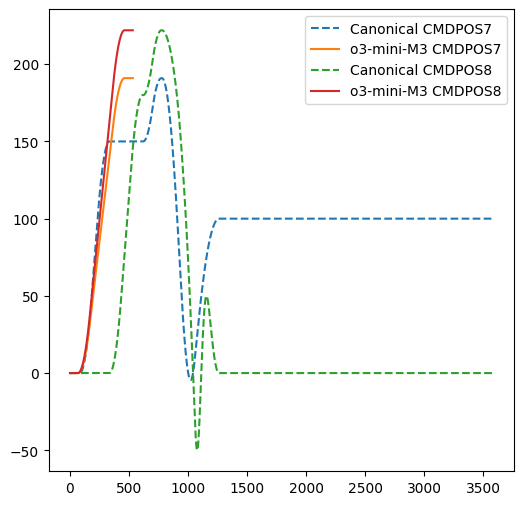

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

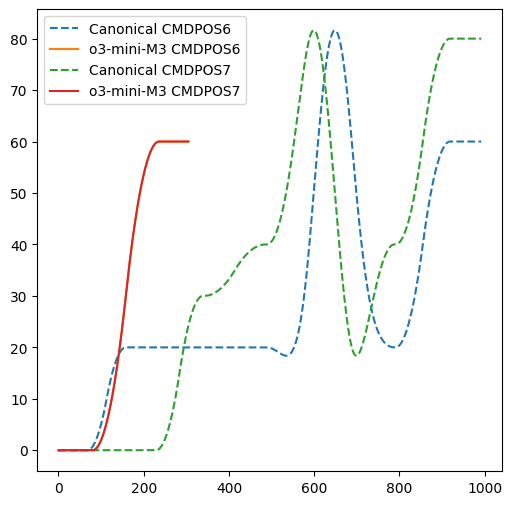

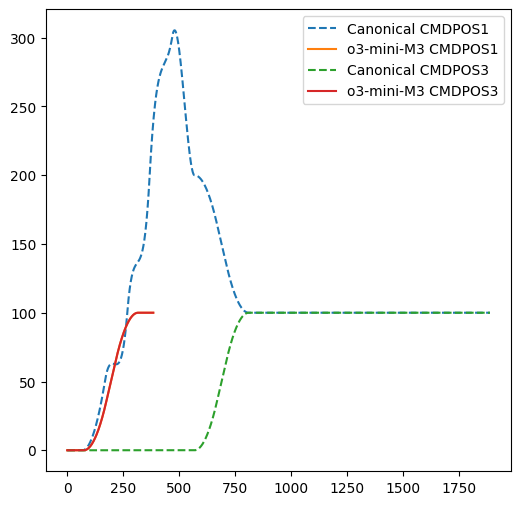

In [62]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from tqdm import tqdm
import json
from tslearn.metrics import dtw

# Define folder paths and LLM name
llm_name = 'o3-mini-M3' 
folder_canonical = f'/Users/yin/Documents/GitHub/MCCodeLog/CanonicalCode'
folder_llm = f'/Users/yin/Documents/GitHub/MCCodeLog/{llm_name}'

# Define task ID range
task_id_range = range(1, 187)

# Initialize result lists for summary
match_endpoints_summary = []
dtw_summary = []

# Load difficulty levels from JSON
with open("./docs/WMX3API_MCEval_Evaluation_Dataset.json", 'r') as file:
    difficulty_data = json.load(file)

difficulty_levels = {task['TaskId']: task['Difficulty'] for task in difficulty_data}

# Initialize counters for statistics
difficulty_match_counts = {1: 0, 2: 0, 3: 0}
difficulty_dtw_zero_counts = {1: 0, 2: 0, 3: 0}
difficulty_totals = {1: 0, 2: 0, 3: 0}
match_endpoints_and_dtw_zero_counts = {1: 0, 2: 0, 3: 0}
total_tasks = len(task_id_range)
match_endpoints_and_dtw_zero_total = 0

# Update difficulty totals
for task in difficulty_data:
    difficulty = task['Difficulty']
    if difficulty in difficulty_totals:
        difficulty_totals[difficulty] += 1

def compare_logs(task_id):
    """
    Compare logs for a given task ID using MatchEndpoints and DTW.
    """
    global total_tasks, match_endpoints_and_dtw_zero_total
    canonical_file = f'{folder_canonical}/{task_id}_CanonicalCode_log.txt'
    llm_file = f'{folder_llm}/{task_id}_{llm_name}_log.txt'
    
    # Check if both files exist
    if not os.path.exists(canonical_file) or not os.path.exists(llm_file):
        match_endpoints_summary.append(f'{task_id}: No log file')
        dtw_summary.append(f'{task_id}: No log file')
        return None

    # Read the log files
    canonical_log = pd.read_csv(canonical_file, delimiter='\t')
    llm_log = pd.read_csv(llm_file, delimiter='\t')

    # **1. 先删除所有值均为空的列**
    canonical_log = canonical_log.dropna(axis=1, how='all')
    llm_log = llm_log.dropna(axis=1, how='all')

    # 获取第一列（保持不变）和其余列（按列名排序）
    first_column = canonical_log.columns[0]  # 'CYCLE'
    sorted_columns = sorted(canonical_log.columns[1:])  # 排序第2列及之后的列
    # 重新排列列顺序
    canonical_log = canonical_log[[first_column] + sorted_columns]

    # 获取第一列（保持不变）和其余列（按列名排序）
    first_column_llm = llm_log.columns[0]  # 'CYCLE'
    sorted_columns_llm = sorted(llm_log.columns[1:])  # 排序第2列及之后的列
    # 重新排列列顺序
    llm_log = llm_log[[first_column_llm] + sorted_columns_llm]



    # Compare MatchEndpoints
    match_endpoints_result, match = compare_match_endpoints(canonical_log, llm_log, task_id)
    match_endpoints_summary.append(match_endpoints_result)

    # Compare DTW
    dtw_result, dtw_zero = compare_dtw(canonical_log, llm_log, task_id)
    dtw_summary.append(str(dtw_zero) + ' ' + dtw_result)

    # Check if both conditions are met
    if match and dtw_zero:
        match_endpoints_and_dtw_zero_total += 1
        difficulty = difficulty_levels.get(task_id, None)
        if difficulty and difficulty in match_endpoints_and_dtw_zero_counts:
            match_endpoints_and_dtw_zero_counts[difficulty] += 1

    try:
        # Plot DTW alignments
        plot_dtw_alignment(canonical_log, llm_log, task_id)
    except:pass


def compare_match_endpoints(canonical_log, llm_log, task_id):
    """
    Compare the last point of each data column in canonical and LLM logs.
    """
    if list(canonical_log.columns) != list(llm_log.columns):
        return f'{task_id}: Endpoints Error - Column names not same', False

    match = True
    for column in canonical_log.columns[1:]:
        if '_0.0' in column:
            continue
        if canonical_log[column].iloc[-1] != llm_log[column].iloc[-1]:
            match = False
            break

    # Update statistics for difficulty level
    difficulty = difficulty_levels.get(task_id, None)
    if difficulty and difficulty in difficulty_match_counts:
        if match:
            difficulty_match_counts[difficulty] += 1

    return f'{task_id}: {"Match" if match else "DifferentEndPoints"}', match

def compare_dtw(canonical_log, llm_log, task_id):
    """
    Compare the DTW distance of each data column in canonical and LLM logs.
    """
    if list(canonical_log.columns) != list(llm_log.columns):
        return f'{task_id}: dtw Error - Column names not same', False

    dtw_distances = {}
    dtw_zero = True
    for column in canonical_log.columns[1:]:
        if '_0.0' in column:
            continue
        canonical_data = canonical_log[column].iloc[1:]
        llm_data = llm_log[column].iloc[1:]
        distance = dtw(canonical_data, llm_data)
        dtw_distances[column] = distance
        if distance != 0:
            dtw_zero = False

    # Update statistics for difficulty level
    difficulty = difficulty_levels.get(task_id, None)
    if difficulty and difficulty in difficulty_dtw_zero_counts:
        if dtw_zero:
            difficulty_dtw_zero_counts[difficulty] += 1

    return f'{task_id}: {dtw_distances}', dtw_zero

def plot_dtw_alignment(canonical_log, llm_log, task_id):
    """
    Plot the DTW alignment for each data column in canonical and LLM logs.
    """
    plt.figure(figsize=(6, 6))
    for column in canonical_log.columns[1:]:
        if '_0.0' in column:
            continue
        canonical_data = canonical_log[column].iloc[1:].values
        llm_data = llm_log[column].iloc[1:].values
        sns.lineplot(x=range(len(canonical_data)), y=canonical_data, label=f'Canonical {column}', linestyle='--')
        sns.lineplot(x=range(len(llm_data)), y=llm_data, label=f'{llm_name} {column}')
    plt.title(f'DTW Alignment for Task ID {task_id}')
    plt.legend()
    plt.savefig(f'{folder_llm}/{task_id}_DTW_Alignment.png')
    plt.close()


def write_results_to_file():
    """
    Write the results to MatchEndpoints.txt and DTW.txt in the LLM folder.
    """
    with open(f'{folder_llm}/MatchEndpoints.txt', 'w') as file:
        for result in match_endpoints_summary:
            file.write(result + '\n')
        correct_matches = len([result for result in match_endpoints_summary if 'Match' in result])
        total_matches = len(match_endpoints_summary)
        file.write(f'Correct Matches: {correct_matches}/{total_matches}\n')
        file.write(f'Match Proportion: {correct_matches/total_matches:.2%}\n')

        for difficulty in difficulty_totals:
            if difficulty_totals[difficulty] > 0:
                match_ratio = difficulty_match_counts[difficulty] / difficulty_totals[difficulty]
                file.write(f'Difficulty {difficulty} Match Proportion: {match_ratio:.2%} ({difficulty_match_counts[difficulty]}/{difficulty_totals[difficulty]})\n')

    with open(f'{folder_llm}/DTW.txt', 'w') as file:
        for result in dtw_summary:
            file.write(result + '\n')
        file.write(f'Total Comparisons: {len(dtw_summary)}\n')

        dtw_zero_counts = sum([1 for result in dtw_summary if 'True' in result])
        file.write(f'DTW Zero Proportion: {dtw_zero_counts}/{len(dtw_summary)}: {dtw_zero_counts/len(dtw_summary):.2%}\n')

        for difficulty in difficulty_totals:
            if difficulty_totals[difficulty] > 0:
                dtw_zero_ratio = difficulty_dtw_zero_counts[difficulty] / difficulty_totals[difficulty]
                file.write(f'Difficulty {difficulty} DTW Zero Proportion: {dtw_zero_ratio:.2%} ({difficulty_dtw_zero_counts[difficulty]}/{difficulty_totals[difficulty]})\n')

    with open(f'{folder_llm}/MatchEndpointsAndDTWZero.txt', 'w') as file:
        file.write(f'Total Match Endpoints and DTW Zero: {match_endpoints_and_dtw_zero_total}/{total_tasks} ({match_endpoints_and_dtw_zero_total/total_tasks:.2%})\n')
        for difficulty in difficulty_totals:
            if difficulty_totals[difficulty] > 0:
                match_endpoints_and_dtw_zero_ratio = match_endpoints_and_dtw_zero_counts[difficulty] / difficulty_totals[difficulty]
                file.write(f'Difficulty {difficulty} Match Endpoints and DTW Zero: {match_endpoints_and_dtw_zero_counts[difficulty]}/{difficulty_totals[difficulty]} ({match_endpoints_and_dtw_zero_ratio:.2%})\n')

# Compare logs for each task_id with progress display
for task_id in tqdm(task_id_range, desc="Comparing logs"):
    compare_logs(task_id)

# Write the results to the respective files
write_results_to_file()
